In [1]:
#importing libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib.ticker import FixedLocator
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import TimeSeriesSplit

C:\Users\joypa\AppData\Local\Temp\ipykernel_14972\3821792194.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [316]:
# Read the CSV files into pandas DataFrames
df1 = pd.read_csv('F:/Works/Collaborative Application Development/Day Data/D19_updated_days.csv')
df2 = pd.read_csv('F:/Works/Collaborative Application Development/Day Data/D21_updated_days.csv') 

In [317]:
# Drop the 'Date' column from both DataFrames
df1 = df1.drop('Date', axis=1)
df2 = df2.drop('Date', axis=1)

In [318]:
# Extract 'Total Registered' column
total_registered_df1 = df1['Total Registered']
total_registered_df1 = total_registered_df1[-28:]

# Extract 'Total Registered' column
total_registered_df2 = df2['Total Registered']
total_registered_df2 = total_registered_df2[-28:]

In [319]:
# Reset index for both DataFrames
total_registered_df1.reset_index(drop=True, inplace=True)
total_registered_df2.reset_index(drop=True, inplace=True)

In [320]:
# Concatenate the DataFrames along the columns axis
df = pd.concat([total_registered_df1, total_registered_df2], axis=1)
print(df)

    Total Registered  Total Registered
0                 16                15
1                 24                11
2                  4                 5
3                 36                 1
4                  1                 1
5                  1                32
6                 18                11
7                 17                17
8                 17                14
9                 16                 9
10                 1                 1
11                 1                 1
12                 1                11
13                12                35
14                 9                12
15                50                29
16                12                17
17                50                 1
18                 1                 1
19                 1                68
20                18                23
21                80                25
22                89                15
23                22                 1
24                45     

In [321]:
# Calculate the mean along the columns axis to combine the values into a single column
df['Total Registered Data'] = df.mean(axis=1).round().astype(int)  # You can replace 'mean' with 'median', 'sum', or any other aggregation function

# Drop the original columns from the concatenated DataFrame
df = df.drop(['Total Registered'], axis=1)

In [322]:
df.reset_index(drop=True, inplace=True)

# Add a new column named "Day" starting from 1
df['Day'] = 'Day ' + (df.index + 1).astype(str)
print(df)

# Save the DataFrame to a CSV file
#df.to_csv('F:/Works/Collaborative Application Development/Merged Dataset (Last 10 Weeks)/Property_Managers.csv', index=False)

    Total Registered Data     Day
0                      16   Day 1
1                      18   Day 2
2                       4   Day 3
3                      18   Day 4
4                       1   Day 5
5                      16   Day 6
6                      14   Day 7
7                      17   Day 8
8                      16   Day 9
9                      12  Day 10
10                      1  Day 11
11                      1  Day 12
12                      6  Day 13
13                     24  Day 14
14                     10  Day 15
15                     40  Day 16
16                     14  Day 17
17                     26  Day 18
18                      1  Day 19
19                     34  Day 20
20                     20  Day 21
21                     52  Day 22
22                     52  Day 23
23                     12  Day 24
24                     23  Day 25
25                      1  Day 26
26                      1  Day 27
27                     23  Day 28


In [323]:
# Ensure 'Week' is treated as a categorical variable
df['Day'] = df['Day'].astype('category')

# Extract 'Total Registered' column
total_registered = df['Total Registered Data']

In [291]:
#For MSE21

# Load your DataFrame from the CSV file
df = pd.read_csv('F:/Works/Collaborative Application Development/Day Data/MSE21_updated_days.csv')

# Drop unnecessary columns
df = df.drop(['Date', 'Day'], axis=1)

# Extract the last 70 rows from the DataFrame
total_registered = df['Total Registered'].tail(28)

# Create a new DataFrame for the last 70 rows with a new 'Day' column
day_column = ['Day ' + str(i) for i in range(1, len(total_registered) + 1)]
day_df = pd.DataFrame({'Total Registered': total_registered.values, 'Day': day_column})

# Save the DataFrame to a CSV file
#day_df.to_csv('F:/Works/Collaborative Application Development/Merged Dataset (Last 10 Weeks)/Education_Property_Managers.csv', index=False)

# Ensure 'Day' is treated as a categorical variable
day_df['Day'] = day_df['Day'].astype('category')
# Extract 'Total Registered' column
total_registered = day_df['Total Registered']
# Display the DataFrame
print(total_registered)

0      9
1      8
2     30
3     30
4     27
5     17
6     16
7      1
8      1
9     37
10    31
11     8
12     1
13     1
14     1
15     1
16     3
17     1
18     1
19     1
20     1
21     1
22     1
23     1
24     1
25     1
26     1
27     2
Name: Total Registered, dtype: int64


In [269]:
# Check the length of the total_registered series
len(total_registered)

28

In [325]:
#train-test split
train = total_registered[:22]
test = total_registered[22:]

In [326]:
# Define the SARIMA parameters
order = (0, 0, 1)  # (p, d, q)
seasonal_order = (0, 1, 1, 7)  # (P, D, Q, S)

In [327]:
# Initialize TimeSeriesSplit for cross-validation
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

In [328]:
# Initialize list to store RMSE values for each fold
rmse_scores = []

# Perform cross-validated training and validation
for train_index, test_index in tscv.split(train):
    # Split train and validation sets for this fold
    train_fold, val_fold = train[train_index], train[test_index]
    
    # Fit SARIMA model
    model = SARIMAX(train_fold, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    
    # Make predictions for the validation set
    pred = model_fit.predict(start=val_fold.index[0], end=val_fold.index[-1])
    
    # Calculate RMSE for this fold
    rmse = np.sqrt(mean_squared_error(val_fold, pred))
    rmse_scores.append(rmse)

# Fit SARIMA model on the entire training data
final_model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
final_model_fit = final_model.fit(disp=False)

# Make predictions on the test set
predictions = final_model_fit.forecast(steps=len(test))

# Calculate RMSE on test set
test_rmse = np.sqrt(mean_squared_error(test, predictions))
print("Test RMSE:", test_rmse)

Test RMSE: 13.56060354726592


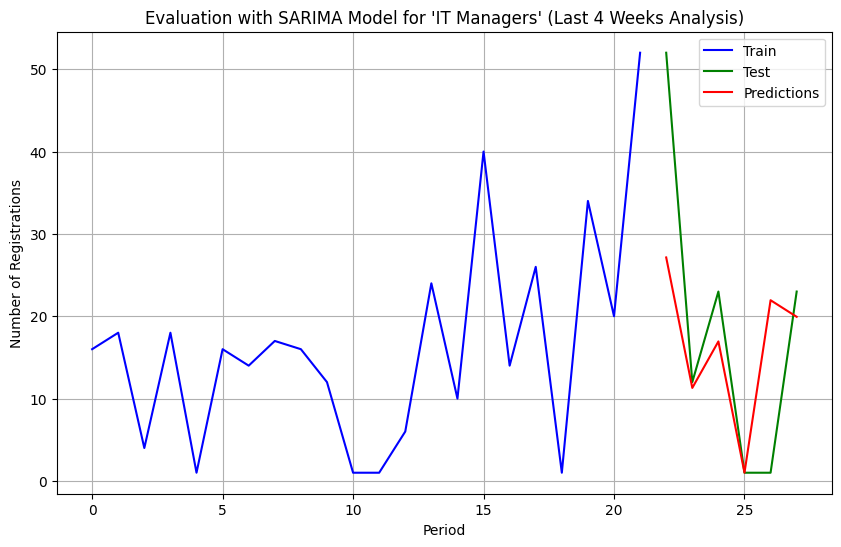

In [329]:
#Plotting the evaluation graph
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test', color='green')
plt.plot(test.index, predictions, label='Predictions', color='red')

# Add labels and title
plt.xlabel('Period')
plt.ylabel('Number of Registrations')
plt.title("Evaluation with SARIMA Model for 'IT Managers' (Last 4 Weeks Analysis)")
plt.legend()
plt.grid(True)

# Save the figure
plt.savefig('F:/Works/Collaborative Application Development/Python/Images/SARIMA_k-Fold/Merged/Last_4_weeks/Training/IT_Managers_SArima_5-fold_80%.png')

In [330]:
# Define the SARIMA model parameters (you need to replace these with your optimal parameters)
order = (0, 0, 1)  # (p, d, q)
seasonal_order = (0, 1, 1, 7)  # (P, D, Q, S)

# Train the SARIMA model on the entire dataset
SARIMA_final_model = SARIMAX(total_registered, order=order, seasonal_order=seasonal_order)
sarima_model_fit_final = SARIMA_final_model.fit()

# Forecast the next 42 days
next_forecast = sarima_model_fit_final.forecast(steps=42)

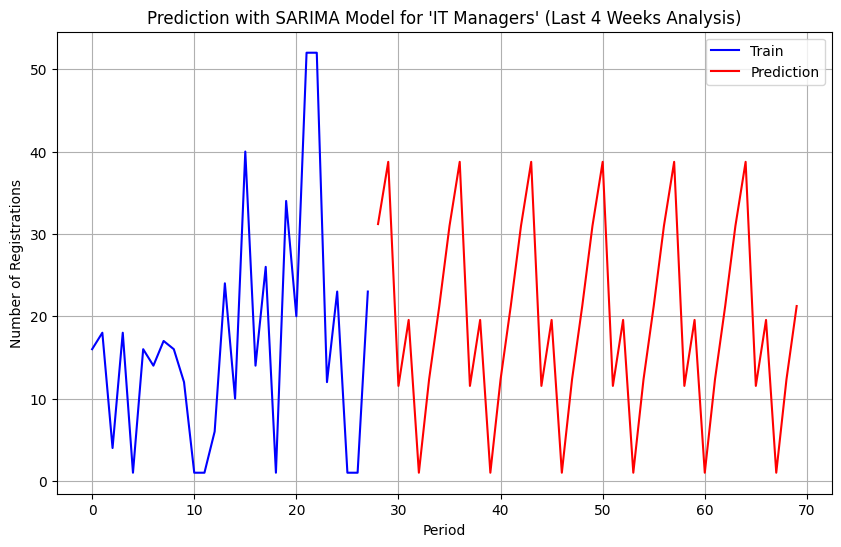

In [332]:
#Plotting the prediction graph
total_registered.plot(legend = True, label = 'Train', color='blue', figsize = (10, 6))
next_forecast.plot(legend = True, label = 'Prediction', color='red')

# Add labels and title
plt.xlabel('Period')
plt.ylabel('Number of Registrations')
plt.title("Prediction with SARIMA Model for 'IT Managers' (Last 4 Weeks Analysis)")
plt.grid(True)

# Save the figure
plt.savefig('F:/Works/Collaborative Application Development/Python/Images/SARIMA_k-Fold/Merged/Last_4_weeks/Prediction/IT_Managers_SArima_5-fold_80%.png')

In [ ]:
#..............................................Finding optimal Hyperparameters..................................................#

In [324]:
# Define the number of folds for cross-validation
n_splits = 5  # You can adjust this number based on your preference

# Define the range for p, d, q, P, D, Q, and m (seasonal period)
p_range = range(0, 3)
d_range = range(0, 2)
q_range = range(0, 3)
P_range = range(0, 3)
D_range = range(0, 2)
Q_range = range(0, 3)
m_values = [7]  # Seasonal period

# Generate all possible combinations of p, d, q, P, D, Q, and m
pdq_combinations = list(itertools.product(p_range, d_range, q_range))
seasonal_pdq_combinations = list(itertools.product(P_range, D_range, Q_range, m_values))

# Initialize lists to store results
rmse_scores = []
parameter_combinations = []

# Initialize TimeSeriesSplit for k-fold cross-validation
tscv = TimeSeriesSplit(n_splits=n_splits)

# Perform k-fold cross-validation
for pdq in pdq_combinations:
    for seasonal_pdq in seasonal_pdq_combinations:
        rmse_scores_fold = []
        for train_index, test_index in tscv.split(total_registered):
            # Split data into training and testing sets
            train = total_registered[train_index]
            test = total_registered[test_index]

            # Ensure that the training set contains at least 56 observations
            if len(train) < 22:
                continue

            # Apply the specified train-test split
            train = total_registered[:22]
            test = total_registered[22:]

            try:
                # Fit SARIMA model and make predictions
                model = SARIMAX(train, order=pdq, seasonal_order=seasonal_pdq, enforce_stationarity=False, enforce_invertibility=False)
                sarima_model_fit = model.fit(disp=False)
                forecast = sarima_model_fit.forecast(steps=len(test))

                # Calculate RMSE for each fold
                rmse_fold = np.sqrt(mean_squared_error(test, forecast))
                rmse_scores_fold.append(rmse_fold)
            except Exception as e:
                print(f'Error fitting model for parameters {pdq} and {seasonal_pdq}: {str(e)}')
                continue
        if rmse_scores_fold:
            # Calculate the mean RMSE across all folds for the current parameter combination
            mean_rmse = np.mean(rmse_scores_fold)
            # Append mean RMSE and corresponding parameter combination to lists
            rmse_scores.append(mean_rmse)
            parameter_combinations.append((pdq, seasonal_pdq))

# Create a DataFrame to store the results
result_df = pd.DataFrame({'Parameter': parameter_combinations, 'Mean RMSE': rmse_scores})

# Sort the DataFrame by Mean RMSE
result_df = result_df.sort_values(by='Mean RMSE')

# Print the DataFrame with mean RMSE values formatted in real numbers
with np.printoptions(formatter={'float': '{:.2f}'.format}):
    print(result_df)

                     Parameter     Mean RMSE
22   ((0, 0, 1), (0, 1, 1, 7))     12.027971
112  ((1, 0, 0), (0, 1, 1, 7))     12.493734
109  ((1, 0, 0), (0, 0, 1, 7))     12.564163
108  ((1, 0, 0), (0, 0, 0, 7))     12.564167
110  ((1, 0, 0), (0, 0, 2, 7))     13.457583
..                         ...           ...
296  ((2, 1, 1), (1, 0, 2, 7))    805.660799
298  ((2, 1, 1), (1, 1, 1, 7))   1065.704285
292  ((2, 1, 1), (0, 1, 1, 7))  23765.267340
310  ((2, 1, 2), (0, 1, 1, 7))  49319.414334
316  ((2, 1, 2), (1, 1, 1, 7))  55487.368129

[324 rows x 2 columns]
